In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Stock/^STOXX50E.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 08:00:00+00:00,3610.060059,3624.030029,3606.969971,3622.550049
2022-10-31 09:00:00+00:00,3613.570068,3617.320068,3608.479980,3610.179932
2022-10-31 10:00:00+00:00,3619.229980,3619.360107,3611.840088,3614.139893
2022-10-31 11:00:00+00:00,3616.199951,3623.199951,3614.709961,3619.350098
2022-10-31 12:00:00+00:00,3615.489990,3617.280029,3612.419922,3616.179932
...,...,...,...,...
2024-10-28 12:00:00+00:00,4953.330078,4954.899902,4932.609863,4938.370117
2024-10-28 13:00:00+00:00,4947.740234,4956.250000,4946.700195,4953.569824
2024-10-28 14:00:00+00:00,4966.339844,4968.569824,4941.839844,4947.729980


In [3]:
# df = dfi.loc[dfi['pickup_datetime'] > '2016-08-01']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,3622.550049,3624.030029,3606.969971,3610.060059
2022-10-31 09:00:00+00:00,3610.179932,3617.320068,3608.479980,3613.570068
2022-10-31 10:00:00+00:00,3614.139893,3619.360107,3611.840088,3619.229980
2022-10-31 11:00:00+00:00,3619.350098,3623.199951,3614.709961,3616.199951
2022-10-31 12:00:00+00:00,3616.179932,3617.280029,3612.419922,3615.489990
...,...,...,...,...
2024-10-28 12:00:00+00:00,4938.370117,4954.899902,4932.609863,4953.330078
2024-10-28 13:00:00+00:00,4953.569824,4956.250000,4946.700195,4947.740234
2024-10-28 14:00:00+00:00,4947.729980,4968.569824,4941.839844,4966.339844


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_2568/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_2568/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4527 entries, 2022-10-31 08:00:00+00:00 to 2024-10-28 16:00:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4527 non-null   float64
 1   High        4527 non-null   float64
 2   Low         4527 non-null   float64
 3   Close       4527 non-null   float64
 4   nxt_target  4527 non-null   float64
dtypes: float64(5)
memory usage: 212.2 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 08:00:00+00:00,3622.550049,3624.030029,3606.969971,3610.060059,3613.570068
2022-10-31 09:00:00+00:00,3610.179932,3617.320068,3608.479980,3613.570068,3619.229980
2022-10-31 10:00:00+00:00,3614.139893,3619.360107,3611.840088,3619.229980,3616.199951
2022-10-31 11:00:00+00:00,3619.350098,3623.199951,3614.709961,3616.199951,3615.489990
2022-10-31 12:00:00+00:00,3616.179932,3617.280029,3612.419922,3615.489990,3616.129883
...,...,...,...,...,...
2024-06-06 14:00:00+00:00,5063.549805,5074.850098,5061.029785,5066.180176,5068.060059
2024-06-06 15:00:00+00:00,5066.200195,5070.649902,5064.680176,5068.060059,5066.669922
2024-06-07 07:00:00+00:00,5072.879883,5077.209961,5063.720215,5066.669922,5045.890137


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 08:00:00+00:00,3613.570068
2022-10-31 09:00:00+00:00,3619.229980
2022-10-31 10:00:00+00:00,3616.199951
2022-10-31 11:00:00+00:00,3615.489990
2022-10-31 12:00:00+00:00,3616.129883
...,...
2024-06-06 14:00:00+00:00,5068.060059
2024-06-06 15:00:00+00:00,5066.669922
2024-06-07 07:00:00+00:00,5045.890137


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,3622.550049,3624.030029,3606.969971,3610.060059
2022-10-31 09:00:00+00:00,3610.179932,3617.320068,3608.479980,3613.570068
2022-10-31 10:00:00+00:00,3614.139893,3619.360107,3611.840088,3619.229980
2022-10-31 11:00:00+00:00,3619.350098,3623.199951,3614.709961,3616.199951
2022-10-31 12:00:00+00:00,3616.179932,3617.280029,3612.419922,3615.489990
...,...,...,...,...
2024-06-06 14:00:00+00:00,5063.549805,5074.850098,5061.029785,5066.180176
2024-06-06 15:00:00+00:00,5066.200195,5070.649902,5064.680176,5068.060059
2024-06-07 07:00:00+00:00,5072.879883,5077.209961,5063.720215,5066.669922


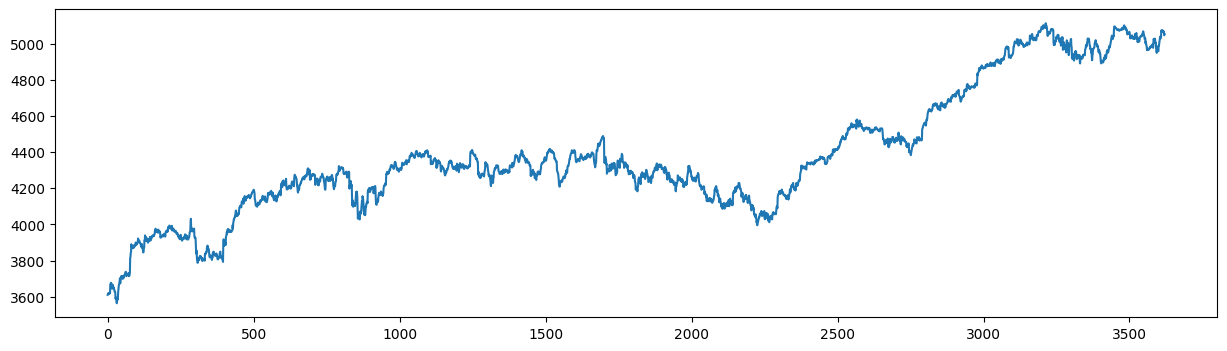

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

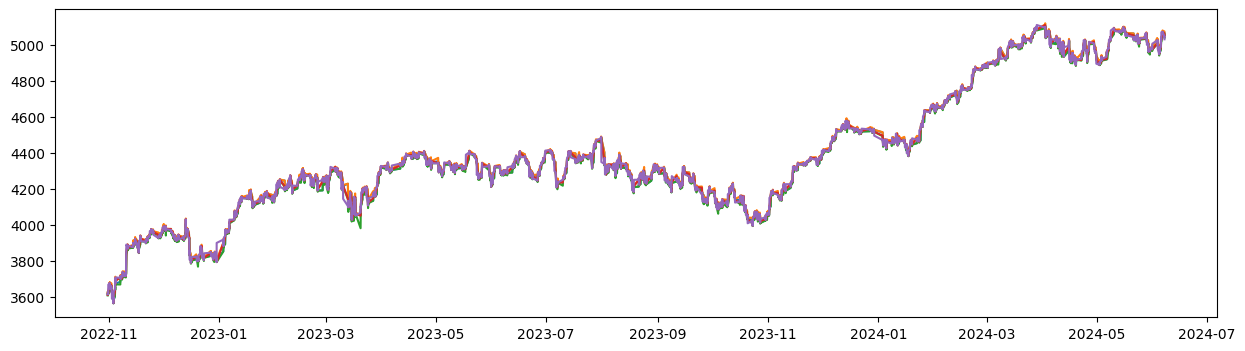

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3611, 10, 4])


tensor([-2.1921, -2.2106, -2.2138, -2.2296])

In [17]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, num_layers =1 ):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=4, hidden_units= 6, num_layers=2)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [19]:
modelQ

ShallowRegressionLSTM(
  (lstm): LSTM(4, 6, num_layers=2, batch_first=True)
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

In [20]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:47.67513614266136 
[2/5]  LossQ:25.152801285917576 
[3/5]  LossQ:31.228489460812852 
[4/5]  LossQ:35.97635114240984 
[5/5]  LossQ:31.383064982914675 


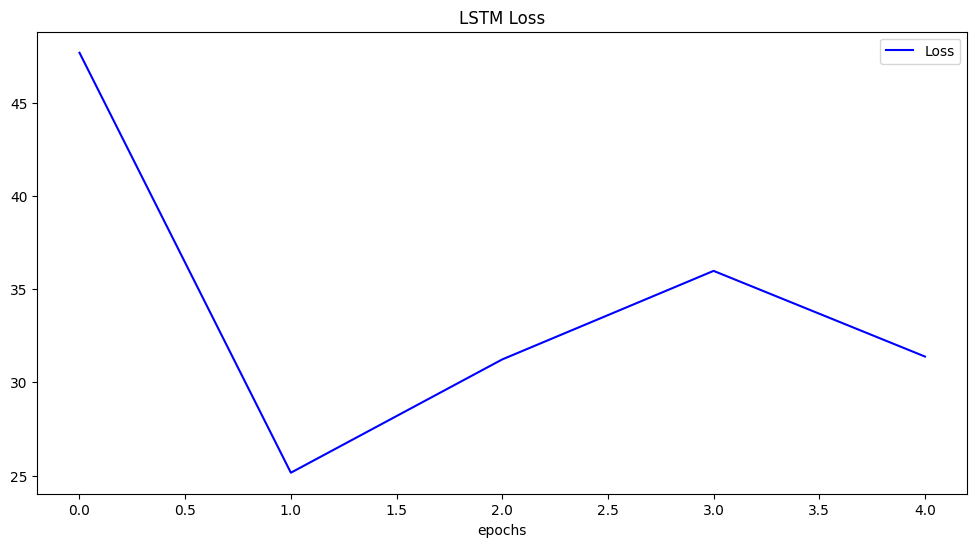

In [21]:
np.savetxt('./SavedModels/Stock/STOXX50E/loss/stacked_clstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [22]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.3254, -0.3281, -0.3285,  ...,  1.9290,  1.9307,  1.9292],
       grad_fn=<ViewBackward0>)


In [23]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [24]:
pred_y_train

tensor([[-0.3254],
        [-0.3281],
        [-0.3285],
        ...,
        [ 1.9290],
        [ 1.9307],
        [ 1.9292]], grad_fn=<ViewBackward0>)

In [25]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [26]:
np.savetxt('./SavedModels/Stock/STOXX50E/train/stacked_clstm.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/STOXX50E/test/stacked_clstm.txt',y_test_pred)

Training dataset RMSE:227.02283293953047


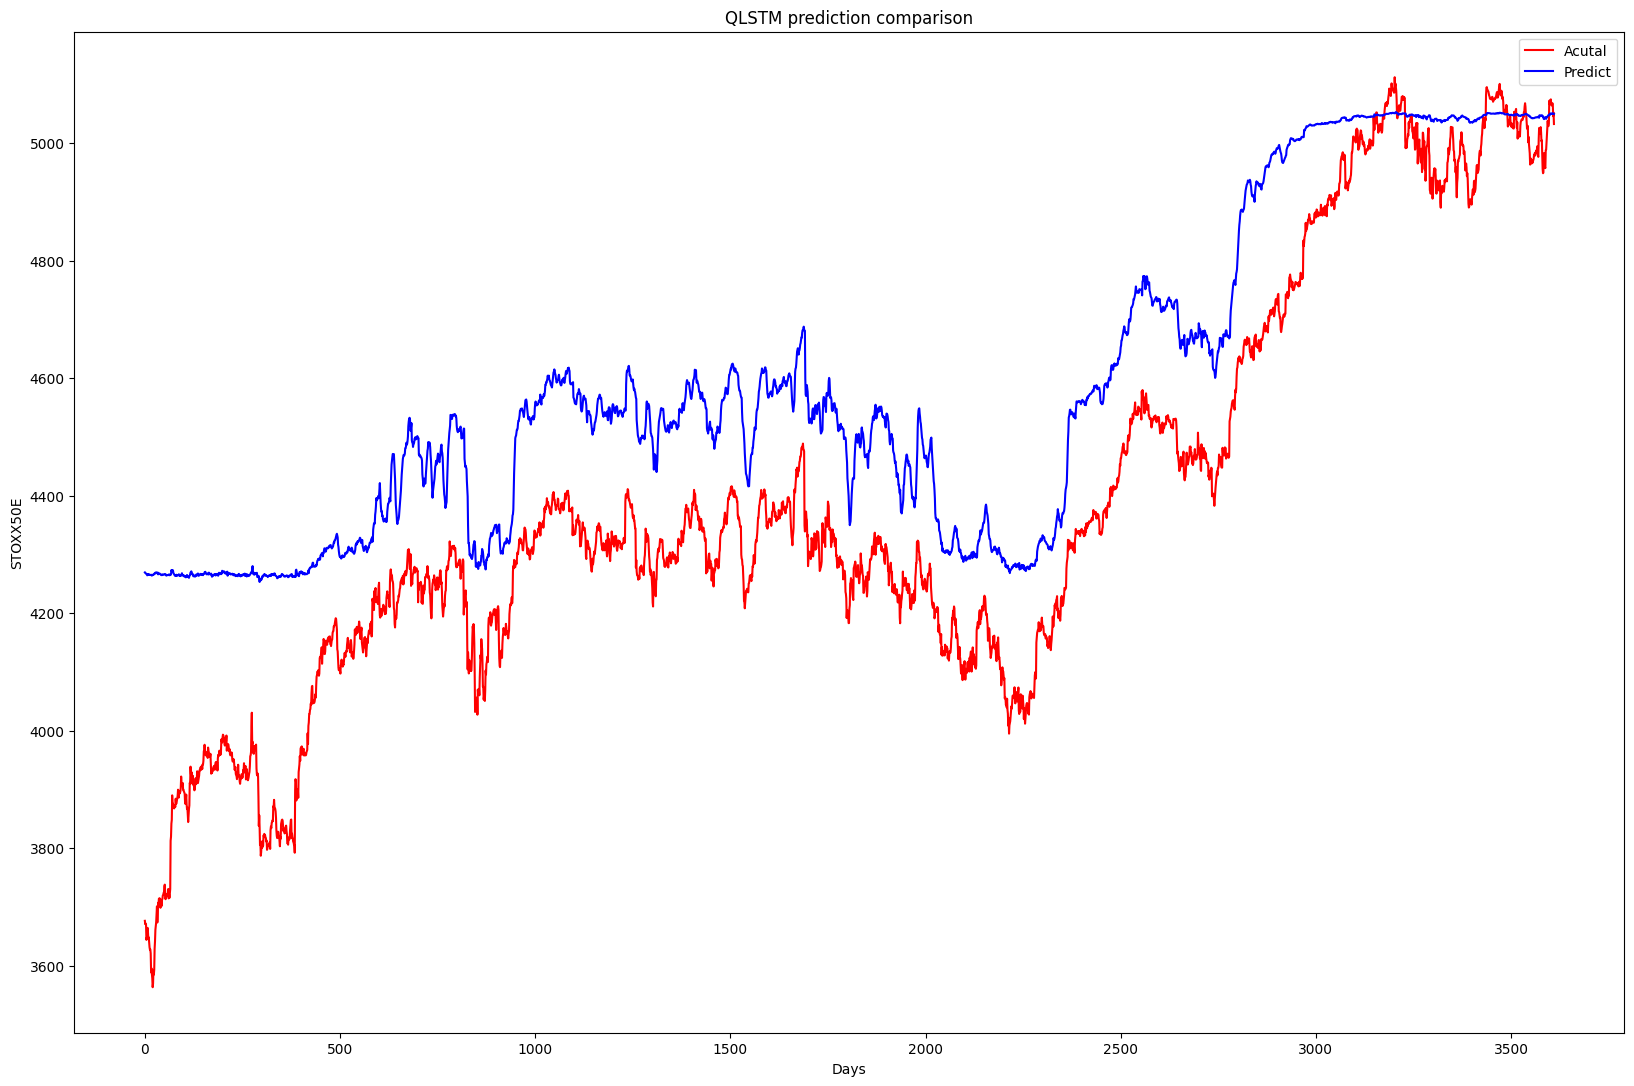

In [27]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('STOXX50E')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:93.9018482572088


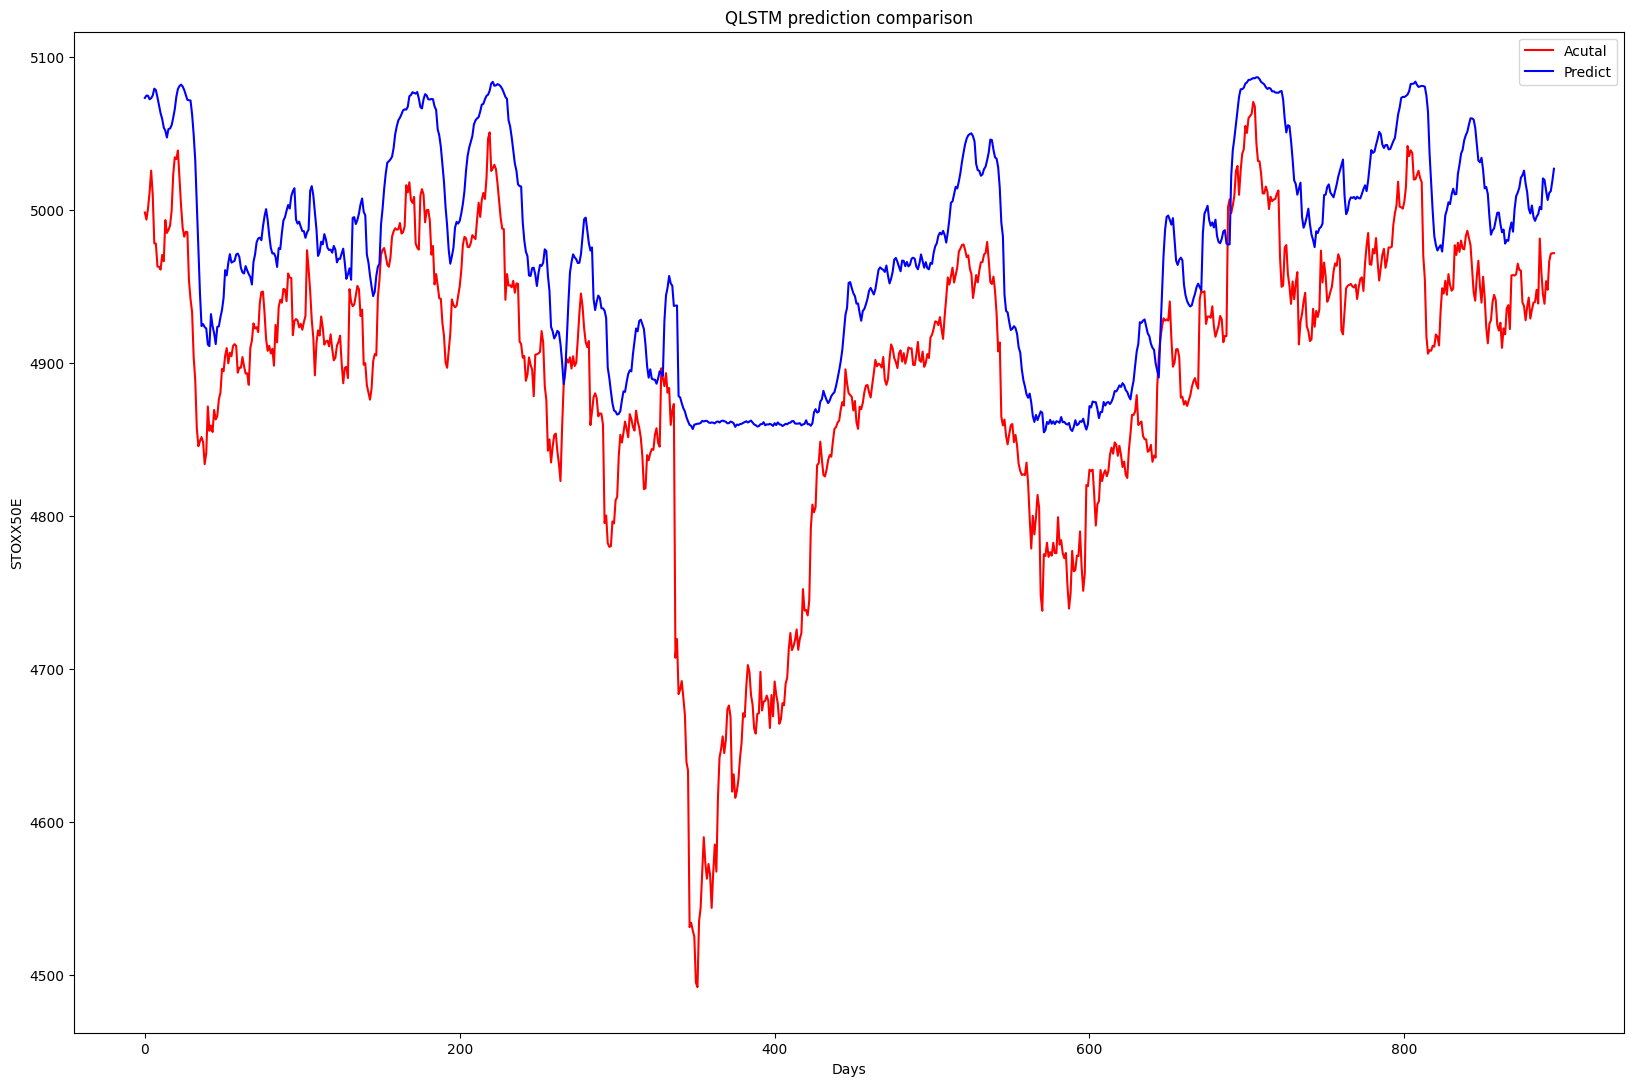

In [28]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('STOXX50E')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [29]:
torch.save(modelQ,'./SavedModels/Stock/STOXX50E/model/stacked_CLSTM_aqi')